**Scrapy SPY and risk free rate proxy BIL from 2000 to now**

In [837]:
import yfinance as yf  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, probplot
import sklearn.mixture as mix

# get data n years from today
def get_price(ticker,start_date,end_date):
    px = yf.download(ticker,start=start_date,end=end_date)['Close']
    return px

df = pd.DataFrame(get_price(['SPY','BIL'],'2000-1-1','2020-12-31'))
df = df.pct_change(periods=1)

[*********************100%***********************]  2 of 2 completed


In [838]:
df.head()

,BIL,SPY
Date,,
1999-12-31,NaN,NaN
2000-01-03,NaN,-0.009787
2000-01-04,NaN,-0.039106
2000-01-05,NaN,0.001789
2000-01-06,NaN,-0.016071


**Fit the histogram of daily return of SPY to Normal Distribution**<br>
The result shows that it does not fit in Normal/Lapace distribution perfectly, though the shape is similar. The deviation from the stright line at 2 ends in the QQ plot shows that it does not follow Normal Distribution. The extreme returns happen more frequently than Normal Distribution.

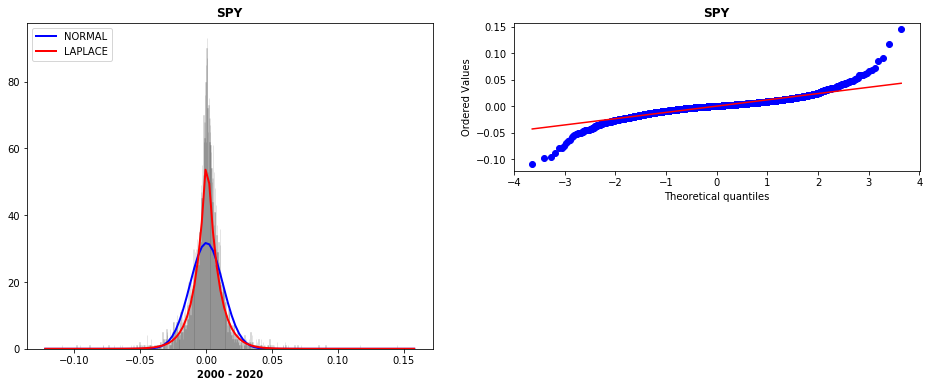

In [845]:
def plot_hist(ticker,df):
    
    df2 = df[ticker].dropna()
    
    # Plot the histogram.
    plt.hist(df2, bins=int(len(df)/5), color='k', edgecolor='black',alpha=0.1)

    # Fit a normal distribution to the data:
    mu, std = norm.fit(df2)
    # Plot 
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'b', linewidth=2,label='NORMAL')

    # Fit a laplace distribution to the data:
    mu, std = laplace.fit(df2)
    # Plot 
    p = laplace.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label='LAPLACE')
    
    #format
    max_y = df2.index.year.unique().max()
    min_y = df2.index.year.unique().min()
    plt.xlabel( str(min_y) + ' - ' + str(max_y), fontweight="bold")
    plt.title(ticker, fontweight="bold")
    plt.legend(loc="upper left")

def plot_qq(ticker,df):
    df2 = df[ticker].dropna()
    probplot(df2, fit=True, plot=plt)

plt.subplot(1,2,1)
plot_hist('SPY',df)
a2 = plt.subplot(2,2,2)
plot_qq('SPY',df)
a2.set_title('SPY', fontweight="bold")

plt.gcf().set_size_inches(16,6)

**Repeat the above QQ-plot year by year**<br>
For somes years, ie 2003-2005, the daily return fits in the Normal distribution well. But most of the time it does not follows Normal. This year (2020), the extreme return even happens more frequently.

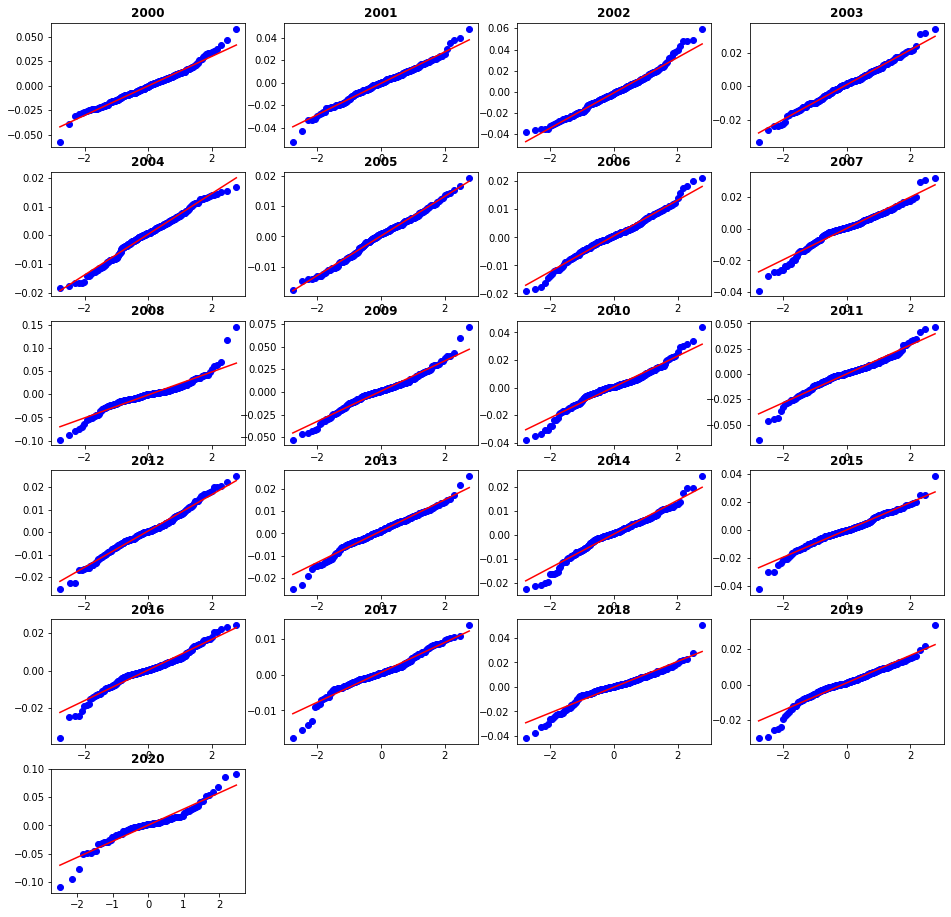

In [840]:
def plot_qq_by_yr(ticker,r,c,df): # r,c = no. of row and column in the subplot
    
    df2 = df[ticker].dropna()
    
    for s, i in enumerate(df2.index.year.unique(), 1):
        a = plt.subplot(r,c,s)
        probplot(df2[df2.index.year==i], fit=True, plot=plt)
        a.set_title(i,fontweight="bold")
        a.set_xlabel('')
        a.set_ylabel('')

plot_qq_by_yr('SPY',6,4,df)
plt.gcf().set_size_inches(16,16)

**What if we try to fit the daily return to a Gaussian Mixture Model?**<br>
Here defined a class GMM_FIT using sk learn library.

In [846]:
class GMM_FIT:
    def __init__(self, df, n_components, max_iter, n_init):
        
        df  = df.dropna().values.reshape(-1, 1)

        gmm = mix.GaussianMixture(n_components=n_components, 
                                  max_iter=max_iter,
                                  n_init=n_init,)
        gmm.fit(df)

        self.aic   = gmm.aic(df)
        self.bic   = gmm.bic(df)
        self.mean  = gmm.means_
        self.var   = gmm.covariances_
        self.w     = gmm.weights_
        self.pred  = gmm.predict(df)       #predict the components X belongs to
        self.pred_p= gmm.predict_proba(df) #predict the prob of X
        self.model = gmm
    
    # mixture pdf
    def pdf(self, x):
        res = 0
        for mu,var,w in zip(self.mean.ravel(), self.var.ravel(), self.w.ravel()):
            res += w*norm.pdf(x,mu,var**0.5)
        return res
    
    # mixture cdf
    def cdf(self, x):
        res = 0
        for mu,var,w in zip(self.mean.ravel(), self.var.ravel(), self.w.ravel()):
            res += w*norm.cdf(x,mu,var**0.5)
        return res
    
    # generate n sample
    def sample(self, n):
        return self.model.sample(n)

**Find optimum number of component in the mixture**<br>
Use 2000-2010 as a training set. BIC is minimized at 3, AIC is minimized at 10.

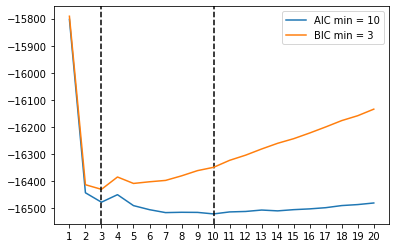

In [322]:
# training set
df_train = df['SPY'][df.index.year<=2010].dropna()

AIC, BIC, n_compo = [], [], []
for i in range(1,21):
    n_compo.append(i)
    AIC.append(GMM_FIT(df_train,i,150,100).aic)
    BIC.append(GMM_FIT(df_train,i,150,100).bic)

plt.plot(AIC,label=f'AIC min = {np.argmin(AIC)+1}')
plt.axvline(np.argmin(AIC), color='k',ls='dashed')
plt.plot(BIC,label=f'BIC min = {np.argmin(BIC)+1}')  
plt.axvline(np.argmin(BIC), color='k',ls='dashed')
plt.xticks(np.arange(len(AIC)), np.arange(1, len(AIC)+1))
plt.legend(loc="upper right")

**Model generation**<br>
BIC is chosen to penalized the additional components more heavily.<br>
So we model the return using 3 components, with mean, standard deviation and weight stated below.

In [847]:
# Build the model based on 2010-2010 data
SPY_3 = GMM_FIT(df_train,3,150,100)

for n, (mu,var,w) in enumerate(zip(SPY_3.mean.ravel(), SPY_3.var.ravel(), SPY_3.w.ravel()),0):
    print ('component',n, ': mean=', np.round(mu,4),',std=' ,np.round(var**0.5,4),',weight=', np.round(w,4))

component 0 : mean= 0.005 ,std= 0.0297 ,weight= 0.1078
component 1 : mean= -0.0064 ,std= 0.0149 ,weight= 0.2082
component 2 : mean= 0.0012 ,std= 0.0077 ,weight= 0.684


**Visualization**<br>
The left plot visualizes the 3 components and the final mixture.<br>
The right plot visualizes the return distribution and which components they belongs to. <br><br>
The component0 (red) accounts for most of the outliers, which appears during the crisis in 2008-2009. Most of the returns belong to component2 (blue) with a narrower range. And the component1 (green) accounts for moderate negative return.

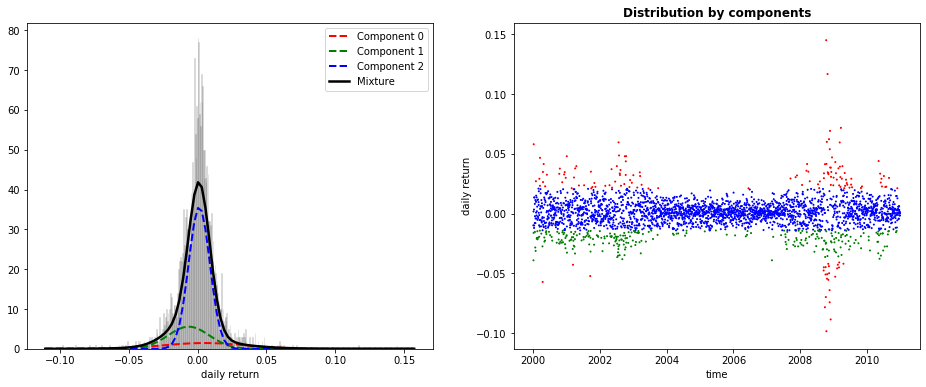

In [1179]:
# sub plot 1: plot the mixture
plt.subplot(1,2,1)

# plot the training data
plt.hist(df_train, bins=int(len(df)/10), color='k', edgecolor='black',alpha=0.1)

# plot the components
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
color = ['r','g','b']

for n, (mu,var,w,c) in enumerate(zip(SPY_3.mean.ravel(), SPY_3.var.ravel(), SPY_3.w.ravel(), color),0):
    p = w*norm.pdf(x, mu, var**0.5)
    plt.plot(x, p, c=c, linewidth=2,label=f'Component {n}',ls='dashed')
    
# plot the mixture
p = SPY_3.pdf(x)
plt.plot(x, p, 'k', linewidth=2.5,label=f'Mixture')
plt.xlabel('daily return')
plt.legend(loc="upper right")

# sub plot 2: plot the distribution by components
# map the components to color
plt.subplot(1,2,2)
color_map={} 
for x,y in zip(np.unique(SPY_3.pred),color):
    color_map[x] = y 
mask = [color_map[x] for x in SPY_3.pred.tolist()]
# plot
plt.scatter(df_train.index,df_train,s=1,c=mask)
plt.xlabel('time')
plt.ylabel('daily return')
plt.title('Distribution by components',fontweight="bold")
plt.gcf().set_size_inches(16,6)

**Trade with the GMM model**<br>
-First generate random sample to predict a series of daily return.<br>
-If generated return at day=d > 0.5%, which is the assumed transaction cost, then we spend 100% of our money to buy SPY at closing price at day d-1 and sell it at day d.<br><br>
Below is a function to simulate return paths and statistics (cummulative return, sharpe ratio) through out the testing period.

In [1239]:
def trade(model, df_test, df_rf, trial, plot_paths):

    # Create lists to 
    # store daily return (time series), cummlative return (time series), total return(single value) and order series 
    # of each simulations
    daily_r, total_r , cum_r, inv = [], [], [], []

    for i in range(trial):

        # generate sample
        sample = model.sample(len(df_test))
        pred  = sample[0].reshape(-1)
        compo = sample[1].reshape(-1)

        # reshuffle sample
        sample = np.c_[pred,compo]
        np.random.shuffle(sample)
        pred  = sample.T[0].reshape(-1)
        compo = sample.T[1].reshape(-1)

        # mapping function
        # function to generate buy order if return > 0.5%
        def buy(x):
            if x>0.005:
                return 1
            else:
                return 0
        # 0 to 1, float(1) is better than 1 as x will become integer if type not specified
        def zero_to_one(x):
            if x==0:
                return float(1)
            else:
                return float(x)

        # genrate buy order
        order = np.vectorize(buy)(pred)
        # daily return of SPY
        d_r_spy     = df_test.to_numpy()
        # a time series of cummulative return of SPY
        cum_r_spy = np.cumprod(1+d_r_spy)
        # log daily return of SPY
        log_d_r_spy = np.log(1+d_r_spy)

        # a time series of daily return of our model
        r = d_r_spy*order
        # a time series of cummulative return of our model
        cum_ret = (1+d_r_spy)*order
        cum_ret = np.vectorize(zero_to_one)(cum_ret)
        cum_ret = np.cumprod(cum_ret)
        # total_return of our strategy
        t_r = np.exp(1)**(sum(log_d_r_spy*order))
        
        # append stat of this simulation
        total_r.append(t_r)
        daily_r.append(r)
        cum_r.append(cum_ret)
        inv.append(order)

        # plot the path
        if plot_paths==1:
            plt.plot(df_test.index,cum_ret,alpha=0.1)
    
    # cummulative return and daily return of our model
    cum_r_model   = np.average(cum_r, axis=0)
    daily_r_model = np.average(daily_r, axis=0)
    order_model   = np.sum(inv, axis=0)
    
    if plot_paths==1:
        plt.plot(df_test.index, cum_r_model, linewidth=1.5, color='r', label='MODEL')
        plt.plot(df_test.index, cum_r_spy, linewidth=1.5, color='k', label='SPY', alpha=0.7)
        plt.axhline(y=1, color='k',ls='dashed',linewidth=1.5,alpha=0.8)
        plt.title('Possible Cummulative Return',fontweight="bold")
        plt.ylabel('cummulative return')  
        plt.xlabel('time')    
        plt.legend(loc="upper left")
        plt.gcf().set_size_inches(16,6)
        
    else:
        
        # statistics
        num_posit     = sum([1 for i in total_r if i>1])
        num_nega      = len(total_r) - num_posit
        
        total_r_spy    = np.prod((df_test+1).to_numpy())-1
        total_r_bil    = np.prod((df_rf+1).to_numpy())-1
        max_loss_spy   = min(cum_r_spy)-1

        
        model_total_r   = np.average(total_r)-1
        model_daily_vol = np.std(daily_r_model)
        model_max_loss  = min(cum_r_model)-1
        model_sharpe    = (np.average(total_r) - 1 - total_r_bil) / (model_daily_vol*(len(df_test)**0.5))  

        # plot histogram of return
        plt.hist(np.array(total_r)-1, bins=int(len(df_test)/2), color='k', edgecolor='black',alpha=0.3)
        plt.xlabel('total return of GMM model')  
        plt.title('Distribution of total Return'+' - '+str(trial)+' simulations',fontweight="bold")
        
        #print statistics
        print('-'*11, 'Model Performance', '-'*11)
        print('no. of simulations:', trial)
        print('no. of trading days:', len(df_test))
        print('no. of +ve return:', num_posit)
        print('no. of -ve return:', num_nega)
        
        print('Total Return:', "{0:.4%}".format(model_total_r))
        print('Daily Volatility:', "{0:.4%}".format(model_daily_vol))
        print('Max Loss during the period:', "{0:.4%}".format(model_max_loss)) 
        print('Sharpe Ratio:', "{0:.4}".format(model_sharpe))
        
        print('-'*15, 'Benchmark', '-'*15)
        print('return of SPY:', "{0:.4%}".format(total_r_spy))
        print('return of BIL:', "{0:.4%}".format(total_r_bil))
        print('Max Loss SPY during the period:', "{0:.4%}".format(max_loss_spy)) 

**2011-2019 vs 2020**<br>
The model gives different results during the 2 periods (using 1000 simulations each). Consider 2011-2019, generally a bull market, most of the cummulative return paths lies above y=1, which means there is a high probability to generate positive return. While in 2020, a relative poorly performed market, only half the return paths lies above y=1. It is likely that the return depends on the market performance.<br>

An interesting point, during 2011-2019, barely no return paths lie above the black solid reference line of SPY return. But in 2020, lots of return paths lie above the solid line, which means the model has high probability to do better than SPY during a relative poorly performed market.

**Model Performance**<br>
The red line is the total return (which is also the mean return) when we bet on all 1000 simulations with same amount of intial investment. The red line follows the trend of SPY (black solid line), but in a smaler magnitude, experiencing a lower volatility. It can be concluded that, during bull market, our model is worse than SPY in terms of return; during a bear market, our model provide a low volatility protection and perform better then SPY relatively.

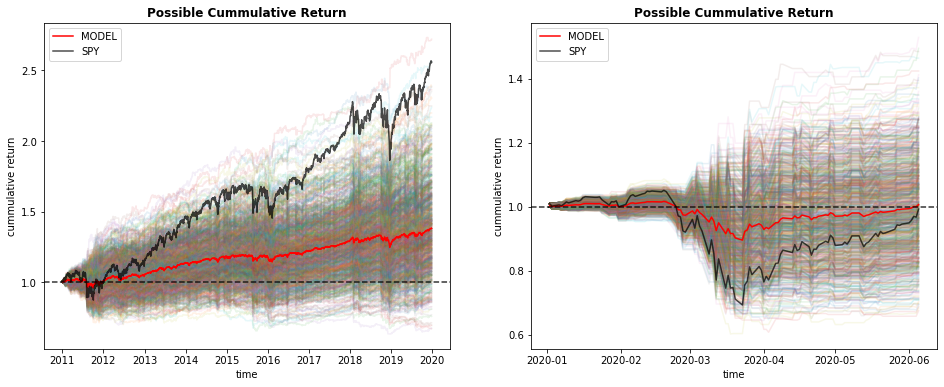

In [1171]:
#2011-2019
plt.subplot(1,2,1)
df_test = df['SPY'][(df.index.year<=2019)&(df.index.year>2010)].dropna()
df_rf   = df['BIL'][(df.index.year<=2019)&(df.index.year>2010)].dropna()
trade(SPY_3, df_test, df_rf, trial=1000,plot_paths=1)

#2020
plt.subplot(1,2,2)
df_test = df['SPY'][df.index.year==2020].dropna()
df_rf   = df['BIL'][df.index.year==2020].dropna()
trade(SPY_3, df_test, df_rf, trial=1000,plot_paths=1)

**Statistics**<br>
Let's take a look into the details of the model performance during 2020, if we run 20000 simulations.<br>
There are slighly more number of -ve returns than +ve returns but the +ve returns can cover the loss of -ve return so it generates a little return (+0.7558%), which beats SPY (-0.7829%) and BIL (0.0984%). We may loss up to 10.23% in the period but still less servere than SPY (-30.73%).

----------- Model Performance -----------
no. of simulations: 20000
no. of trading days: 108
no. of +ve return: 9894
no. of -ve return: 10106
Total Return: 0.7558%
Daily Volatility: 0.9183%
Max Loss during the period: -10.2658%
Sharpe Ratio: 0.06889
--------------- Benchmark ---------------
return of SPY: -0.7829%
return of BIL: 0.0984%
Max Loss SPY during the period: -30.7308%


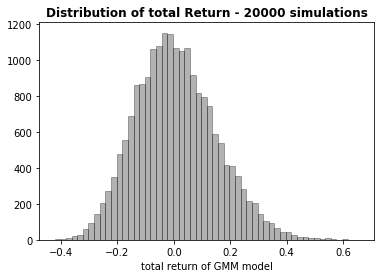

In [1243]:
df_test = df['SPY'][df.index.year==2020].dropna()
df_rf   = df['BIL'][df.index.year==2020].dropna()
trade(SPY_3, df_test, df_rf, trial=20000,plot_paths=0)

**Conclusion**<br>
1.Our model can provide protection/return enhancement during a downtrend by reducing the volatility. It is not suitable during a bull market as the returns is dragged.<br>
2.By the law of large numbers, we should make simulation as many as possible. It is not necessary to make a large number of order in reality as we can net the order.<br>
3.It may not be feasible to accurately execute the order at close price.<br>

**What's Next**<br>
1.This is a univariate model, what if we do multivariate GMM, ie. a stock + bond prediction (SPY + GOVT).<br>
2.Can we improve the return during bear market by adding some short orders? Or it worsens the return by making more prediction error?<br>
3.How many order we need to make, and how many inventory we hold per day?